### Final Propensity matching results

In [1]:
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [3]:
%reload_ext Cython

In [4]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [5]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR, make_MYR_to_date
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')
from utils import statistics_first_month, p_val, stat_matrices 
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [6]:
# #setup cython
# #for cython build if needed -> cd to /modules folder and then run
# %cd ..
# !python3 setup.py build_ext --inplace
# %cd ./causal_data_creation/canary_application/

In [7]:
%config Completer.use_jedi = False

### Load pre matching data

In [8]:
pp_str = 'Pre_Matching_DATA/'
Path("./"+pp_str).mkdir(exist_ok=True)

In [9]:
# %%time
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/treated2.p ./Pre_Matching_DATA/treated2.p; 
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/controls.p ./Pre_Matching_DATA/controls.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/pmpm.p ./Pre_Matching_DATA/pmpm.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/tempHybridSelectionMoreData/random.p ./Pre_Matching_DATA/random.p;

In [10]:
treated = pd.read_pickle(pp_str+'treated2.p')
controls = pd.read_pickle(pp_str+'controls.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle(pp_str+'random.p')

In [11]:
pmpm.MBR_GNDR.replace({"F":0,"M":1}, inplace=True)

In [12]:
treated.shape, treated.MYR.min(), treated.MYR.max()

((26040, 91), 201710, 202107)

In [13]:
controls.shape, controls.MYR.min(), controls.MYR.max()

((9582196, 91), 201701, 202107)

In [14]:
pmpm.shape, pmpm.MYR.min(), pmpm.MYR.max()

((9650961, 91), 201701, 202107)

# Check continuity and take average of 1 year history

### Treated

In [15]:
# def get_treated_agg(treated, pmpm):
    
#     #get one year before dates
#     treated_history = pmpm[pmpm.PERS_ID.isin(treated.PERS_ID)]
#     treated.drop(['MEDICAID_LOB'], axis=1, inplace=True)
#     treated['MYR_12'] = treated.MYR.apply(data_process.get_one_year_before, month_offset=12)
    
#     treated_aggregate = pd.DataFrame(columns=col_seq_can_all)
#     for i, (index, row) in tqdm(enumerate(treated.iterrows())):
#         pid = row.PERS_ID
#         myr = row.MYR
#         old_myr = row.MYR_12
#         history = treated_history.query("PERS_ID==@pid & MYR>=@old_myr & MYR<=@myr")
#         agg_data = history[col_seq_can_all].mean()
#         agg_data.PERS_ID = str(int(row.PERS_ID))
#         agg_data.MYR     = int(row.MYR)
#         treated_aggregate = pd.concat([treated_aggregate, pd.DataFrame(agg_data).T], axis=0)
            
#     treated_aggregate.PERS_ID = treated_aggregate.astype(int).astype(str)
#     treated_aggregate.MYR = treated_aggregate.MYR.astype(int)
    
#     treated_aggregate = treated_aggregate.reset_index(drop=True)
    
#     return treated_aggregate
    

In [16]:
# %%time
# treated_aggregate = get_treated_agg(treated.copy(), pmpm.copy())
# treated_aggregate.to_pickle("./FinalData/treated_aggregated_filtered_final_g.p")

In [17]:
sorted_months = treated.MYR.sort_values().unique()

In [18]:
sorted_months

array([201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805,
       201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901,
       201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909,
       201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005,
       202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101,
       202102, 202103, 202104, 202105, 202106, 202107])

In [19]:
treated_aggregate = pd.read_pickle("./Final/Data/PCA/treated_aggregated_filtered_final.p") #goes into matching as tr_agg

In [20]:
# controls_aggregate = data_process.get_average_final_record(controls.copy(), sorted_months, pmpm[col_seq_can_all].copy())
# controls_aggregate.to_pickle("./Final/Data/PCA/controls_aggregated_filtered_final.p")

In [21]:
controls_aggregate = pd.read_pickle("./Final/Data/PCA/controls_aggregated_filtered_final.p")

In [22]:
treated_original = treated[treated.set_index(['PERS_ID','MYR']).index.isin(treated_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)
controls_original = controls[controls.set_index(['PERS_ID','MYR']).index.isin(controls_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [23]:
del treated, controls

In [24]:
# !aws s3 cp ./Final/Data/PCA/treated_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/treated_agg.p --acl bucket-owner-full-control
# !aws s3 cp ./Final/Data/PCA/controls_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/controls_agg.p --acl bucket-owner-full-control

# Load Model and Pick Columns for Matching

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [26]:
model_t = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=16))])
model_c = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=16))])

In [27]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [28]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", 'AGE_AT_MIDMONTH', 'MBR_GNDR',  onset]
extra_cols = ['IP_BIN6', 'ER_BIN6','LOB']

In [29]:
treated_latent = pd.DataFrame(model_t.fit_transform(treated_aggregate[col_seq_can_all].loc[:,'AGE_AT_MIDMONTH':]), columns=latent_cols)
treated_latent1 = pd.concat([treated_aggregate[cols_to_keep], treated_original[extra_cols]], axis=1)
treated_latent = pd.concat([treated_latent1, treated_latent], axis=1)

In [30]:
controls_latent = pd.DataFrame(model_c.fit_transform(controls_aggregate[col_seq_can_all].loc[:,'AGE_AT_MIDMONTH':]), columns=latent_cols)
controls_latent1 = pd.concat([controls_aggregate[cols_to_keep], controls_original[extra_cols]], axis=1)
controls_latent = pd.concat([controls_latent1, controls_latent], axis=1)

In [31]:
del treated_latent1, controls_latent1

In [32]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [33]:
controls_latent.shape, controls_original.shape

# Matching

In [36]:
%%time
match_on = latent_cols
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched0, matched_data0 = matched_population(treated_latent.copy(), 
                                           controls_latent.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:271336 before they were:304151


0it [00:00, ?it/s]

IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None


1568it [1:01:29,  2.35s/it]


There were no matches for 1 out of 1568 patients
CPU times: user 1h 32s, sys: 36min 6s, total: 1h 36min 39s
Wall time: 1h 1min 34s


In [39]:
def get_data(data_struct):
    keys = list(data_struct)
    dat1 = pd.DataFrame()
    for key in keys:
        dat1 = pd.concat([dat1, data_struct[key]], ignore_index=True)
    return dat1

In [41]:
matched_controls_5N = get_data(matched0)

In [42]:
matched_controls_5N.to_pickle("./Final/Data/PCA/matched_controls_5N.p")

In [54]:
matched_data0.to_pickle("./Final/Data/PCA/matched_controls_latent.p")

### Calculate matched controls agg and matched controls original 

In [48]:
matched_controls_original = controls_original[controls_original.set_index(['PERS_ID','MYR']).index.isin(matched_data0.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [50]:
matched_controls_original.to_pickle("./Final/Data/PCA/matched_controls_original.p")

In [51]:
matched_controls_aggregate = controls_aggregate[controls_aggregate.set_index(['PERS_ID','MYR']).index.isin(matched_data0.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [52]:
matched_controls_aggregate.to_pickle("./Final/Data/PCA/matched_controls_aggregate.p")

### List containing all numerical columns

In [54]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

# Statistics First Month Original

In [ ]:
# del controls, controls2

In [57]:
treated = pd.read_pickle(pp_str+'treated2.p')

In [60]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, all_columns, return_array = True)

pmpm_desc = statistics_first_month(pmpm, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)


CPU times: user 2min 34s, sys: 7.39 s, total: 2min 41s
Wall time: 2min 41s


In [61]:
conds_first

Treated Matched Controls    Test-TC               General Population      Random
                       mean             mean     t-stat          pval               mean        mean
AGE_AT_MIDMONTH   50.205736        50.734821  -1.449626  1.472053e-01          44.310976   47.606399
ALLOW_AMT        693.750000       654.573949   0.594809  5.519897e-01        1065.926022  648.802692
MBR_GNDR           0.205736         0.230410  -2.093951  3.629836e-02           0.442749    0.431056
CC_TOBACCO         0.061097         0.109151  -5.720503  1.103600e-08           0.074202    0.098400
CC_PRESSURE        0.001247         0.008822  -3.181691  1.470244e-03           0.007390    0.006602
CC_OBESITY         0.456359         0.389206   4.856804  1.217507e-06           0.108841    0.228035
CC_HYPERTENSION    0.324813         0.377962  -3.912255  9.225908e-05           0.207717    0.249365
CC_HYPOTHYROID     0.094763         0.056565   5.506494  3.783580e-08           0.047300    0.063484
CC_DX_CNT          2.706359         2.857464  -2.795589  5.193904e-03           1.824419    2.343702
ACUTE2             0.038653         0.048435  -1.573868  1.155608e-01           0.063258    0.051549
ACUTE6             0.111596         0.139422  -2.411167  1.592581e-02           0.063258    0.153377
IP_BIN6            0.028055         0.031136  -0.575141  5.652134e-01           0.020587    0.046851
ER_BIN6            0.088529         0.112264  -2.304322  2.123218e-02           0.047286    0.116176
LOB                0.951995         0.823041  12.977888  4.254564e-38           0.755775    0.787836

In [62]:
conds_first.to_csv("./Final/results/pca/stats_matching/conds_original_first.csv", index=True, header=True)
full_first.to_csv("./Final/results/pca/stats_matching/full_original_first.csv", index=True, header=True)
conds_firstAllCols.to_csv("./Final/results/pca/stats_matching/conds_original_first_allcols.csv", index=True, header=True)
full_firstAllCols.to_csv("./Final/results/pca/stats_matching/full_original_first_allcols.csv", index=True, header=True)

# Latent First Month

In [68]:
%%time
tr_desc0_l, treated_first_month_l = statistics_first_month(treated_latent, latent_cols, return_array = True)
con_desc0_l, controls_first_month_l = statistics_first_month(matched_data0, latent_cols, return_array = True)

conds_lat, full_lat = stat_matrices(tr_desc0_l, con_desc0_l, tr_desc0_l, tr_desc0_l, columns = latent_cols)


CPU times: user 2.37 s, sys: 1.34 ms, total: 2.37 s
Wall time: 2.37 s


In [70]:
conds_lat

Treated Matched Controls   Test-TC               General Population    Random
         mean             mean    t-stat          pval               mean      mean
x1  -0.169575        -0.480720  6.971309  3.412760e-12          -0.169575 -0.169575
x2  -0.051928        -0.061076  0.228415  8.193299e-01          -0.051928 -0.051928
x3   0.158255         0.055112  2.788808  5.303860e-03           0.158255  0.158255
x4  -0.015325        -0.180550  4.979349  6.525208e-07          -0.015325 -0.015325
x5   0.013630         0.058080 -1.707370  8.779561e-02           0.013630  0.013630
x6   0.048210        -0.173819  7.602678  3.260613e-14           0.048210  0.048210
x7  -0.056737        -0.042264 -0.551420  5.813627e-01          -0.056737 -0.056737
x8  -0.035397        -0.024437 -0.431641  6.660153e-01          -0.035397 -0.035397
x9   0.092452         0.059669  1.277345  2.015210e-01           0.092452  0.092452
x10  0.007016         0.028823 -0.882615  3.774734e-01           0.007016  0.007016
x11 -0.021615        -0.122770  4.177537  2.980937e-05          -0.021615 -0.021615
x12 -0.024759        -0.096286  3.004887  2.665762e-03          -0.024759 -0.024759
x13 -0.004937         0.045104 -2.203457  2.759348e-02          -0.004937 -0.004937
x14  0.018578        -0.016349  1.502144  1.331028e-01           0.018578  0.018578
x15 -0.023011        -0.140457  5.385405  7.451957e-08          -0.023011 -0.023011
x16  0.019445        -0.063584  3.520841  4.327890e-04           0.019445  0.019445

In [71]:
conds_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/conds_lat_first.csv", index=True, header=True)
full_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/full_lat_first.csv", index=True, header=True)

# Agg First Month

In [76]:
%%time
without_custom_cols = [cols for cols in all_columns if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]
selected_without_custom_cols = [cols for cols in columns_to_match if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]

tr_desc0_agg, treated_agg_first_month = statistics_first_month(treated_aggregate, without_custom_cols, return_array = True)
con_desc0_agg, controls_agg_first_month = statistics_first_month(matched_controls_aggregate, without_custom_cols, return_array = True)

conds_agg, full_agg = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllCols, full_aggAllCols = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)


CPU times: user 2.81 s, sys: 76.3 ms, total: 2.89 s
Wall time: 2.89 s


In [77]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].round(3)

Treated Matched Controls Test-TC       
                    mean             mean  t-stat   pval
AGE_AT_MIDMONTH   49.948           50.265  -0.862  0.389
ALLOW_AMT        781.696          631.433   4.395  0.000
MBR_GNDR           0.205            0.230  -2.107  0.035
CC_TOBACCO         0.055            0.092  -5.119  0.000
CC_PRESSURE        0.001            0.008  -3.152  0.002
CC_OBESITY         0.419            0.340   6.442  0.000
CC_HYPERTENSION    0.314            0.349  -2.923  0.003
CC_HYPOTHYROID     0.088            0.049   6.474  0.000
CC_DX_CNT          2.537            2.558  -0.422  0.673
LOB                0.953            0.822  13.197  0.000

In [78]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/conds_agg_first.csv", index=True, header=True)
full_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/full_agg_first.csv", index=True, header=True)
conds_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/conds_agg_first_allcols.csv", index=True, header=True)
full_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/full_agg_first_allcols.csv", index=True, header=True)

# Stat all Original

In [79]:
%%time
tr_desc0A = treated[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

pmpm_descA = pmpm[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)


CPU times: user 28.2 s, sys: 12.1 s, total: 40.3 s
Wall time: 40.3 s


In [80]:
conds.round(3)

Treated Matched Controls Test-TC      General Population   Random
                    mean             mean  t-stat pval               mean     mean
AGE_AT_MIDMONTH   50.837           51.546  -7.959  0.0             50.379   50.236
ALLOW_AMT        782.435          695.881   3.524  0.0            857.856  706.609
MBR_GNDR           0.189            0.216  -9.130  0.0              0.433    0.429
CC_TOBACCO         0.063            0.118 -25.215  0.0              0.102    0.100
CC_PRESSURE        0.002            0.008  -9.800  0.0              0.013    0.008
CC_OBESITY         0.505            0.404  28.845  0.0              0.255    0.286
CC_HYPERTENSION    0.325            0.379 -15.786  0.0              0.329    0.300
CC_HYPOTHYROID     0.095            0.067  15.468  0.0              0.078    0.075
CC_DX_CNT          2.918            3.073 -10.437  0.0              2.955    2.759
ACUTE2             0.032            0.042  -6.883  0.0              0.060    0.050
ACUTE6             0.100            0.129 -10.336  0.0              0.168    0.150
IP_BIN6            0.025            0.035  -6.678  0.0              0.055    0.049
ER_BIN6            0.079            0.100  -8.291  0.0              0.122    0.111
LOB                0.953            0.814  55.281  0.0              0.802    0.803

In [81]:
conds.to_csv("./Final/results/pca/stats_matching/conds_original.csv", index=True, header=True)
full.to_csv("./Final/results/pca/stats_matching/full_original.csv", index=True, header=True)
conds_AllCols.to_csv("./Final/results/pca/stats_matching/conds_original_allcols.csv", index=True, header=True)
full_AllCols.to_csv("./Final/results/pca/stats_matching/full_original_allcols.csv", index=True, header=True)

# Latent Alltime

In [95]:
%%time
tr_desc0_latA = treated_latent[latent_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_latA['count'] = tr_desc0_latA['count'].astype(int)

con_desc0_latA = matched_data0[latent_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_latA['count'] = con_desc0_latA['count'].astype(int)

conds_latA, full_latA = stat_matrices(tr_desc0_latA, con_desc0_latA, tr_desc0_latA, tr_desc0_latA, columns = latent_cols)


CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 152 ms


In [153]:
treated_latent[latent_cols].mean()*(10**14)

x1     0.101314
x2     0.164897
x3     0.001541
x4    -0.016932
x5     0.021146
x6    -0.010401
x7     0.027520
x8     0.022617
x9     0.036462
x10    0.021601
x11   -0.015557
x12   -0.005306
x13   -0.003963
x14   -0.005677
x15   -0.010977
x16    0.013739
dtype: float64

In [154]:
full_latA

Treated                  Matched Controls                     Test-TC                General Population                  Test-TG             Random                  Test-TR     
             mean       std  count             mean       std  count     t-stat           pval               mean       std  count  t-stat pval          mean       std  count  t-stat pval
x1   1.670841e-16  2.114710  24495        -0.269459  1.486827  88209  22.696818  8.681036e-114       1.670841e-16  2.114710  24495     0.0  1.0  1.670841e-16  2.114710  24495     0.0  1.0
x2   3.712981e-17  1.815793  24495         0.045300  1.369186  88209  -4.244403   2.193509e-05       3.712981e-17  1.815793  24495     0.0  1.0  3.712981e-17  1.815793  24495     0.0  1.0
x3  -2.320613e-17  1.571615  24495         0.019044  1.102063  88209  -2.162118   3.061121e-02      -2.320613e-17  1.571615  24495     0.0  1.0 -2.320613e-17  1.571615  24495     0.0  1.0
x4  -3.712981e-17  1.519509  24495        -0.263152  0.923474  88209  33.695801  1.146325e-247      -3.712981e-17  1.519509  24495     0.0  1.0 -3.712981e-17  1.519509  24495     0.0  1.0
x5   1.717254e-16  1.438834  24495        -0.002812  0.806017  88209   0.397655   6.908853e-01       1.717254e-16  1.438834  24495     0.0  1.0  1.717254e-16  1.438834  24495     0.0  1.0
x6  -4.641226e-17  1.390925  24495        -0.252063  0.928867  88209  33.340977  1.506565e-242      -4.641226e-17  1.390925  24495     0.0  1.0 -4.641226e-17  1.390925  24495     0.0  1.0
x7   4.409165e-17  1.371591  24495        -0.115286  0.683344  88209  18.139969   1.961544e-73       4.409165e-17  1.371591  24495     0.0  1.0  4.409165e-17  1.371591  24495     0.0  1.0
x8   7.890085e-17  1.310099  24495        -0.003657  0.868033  88209   0.515995   6.058592e-01       7.890085e-17  1.310099  24495     0.0  1.0  7.890085e-17  1.310099  24495     0.0  1.0
x9   9.282453e-18  1.236598  24495         0.027782  0.624902  88209  -4.816034   1.466290e-06       9.282453e-18  1.236598  24495     0.0  1.0  9.282453e-18  1.236598  24495     0.0  1.0
x10  4.177104e-17  1.205020  24495         0.034357  0.704765  88209  -5.668227   1.446340e-08       4.177104e-17  1.205020  24495     0.0  1.0  4.177104e-17  1.205020  24495     0.0  1.0
x11  1.624429e-16  1.153457  24495        -0.109063  0.768264  88209  17.424099   6.650538e-68       1.624429e-16  1.153457  24495     0.0  1.0  1.624429e-16  1.153457  24495     0.0  1.0
x12 -5.685502e-17  1.139353  24495        -0.070874  0.798265  88209  11.105170   1.225181e-28      -5.685502e-17  1.139353  24495     0.0  1.0 -5.685502e-17  1.139353  24495     0.0  1.0
x13  6.381686e-17  1.134502  24495         0.044442  0.776770  88209  -7.096165   1.290180e-12       6.381686e-17  1.134502  24495     0.0  1.0  6.381686e-17  1.134502  24495     0.0  1.0
x14 -8.586269e-17  1.122501  24495        -0.057646  0.801984  88209   9.053463   1.406336e-19      -8.586269e-17  1.122501  24495     0.0  1.0 -8.586269e-17  1.122501  24495     0.0  1.0
x15 -3.829012e-17  1.090650  24495        -0.156942  0.714474  88209  26.787635  1.408621e-157      -3.829012e-17  1.090650  24495     0.0  1.0 -3.829012e-17  1.090650  24495     0.0  1.0
x16  3.712981e-17  1.062650  24495        -0.065040  0.690894  88209  11.446054   2.557867e-30       3.712981e-17  1.062650  24495     0.0  1.0  3.712981e-17  1.062650  24495     0.0  1.0

In [98]:
conds_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/conds_lat_allcols.csv", index=True, header=True)
full_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/full_lat_allcols.csv", index=True, header=True)

# Agg alltime

In [99]:
%%time
tr_desc0_aggA = treated_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_aggA['count'] = tr_desc0_aggA['count'].astype(int)

con_desc0_aggA = matched_controls_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_aggA['count'] = con_desc0_aggA['count'].astype(int)

conds_aggA, full_aggA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllColsA, full_aggAllColsA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)



CPU times: user 597 ms, sys: 12.5 ms, total: 610 ms
Wall time: 609 ms


In [100]:
conds_aggA

Treated Matched Controls    Test-TC                General Population      Random
                       mean             mean     t-stat           pval               mean        mean
AGE_AT_MIDMONTH   50.580075        51.056575  -5.232352   1.676650e-07          49.947968   49.947968
ALLOW_AMT        808.023126       685.655576  11.210378   3.757689e-29         781.696414  781.696414
MBR_GNDR           0.191590         0.215640  -8.172358   3.055146e-16           0.205357    0.205357
CC_TOBACCO         0.062304         0.109219 -23.194685  9.793660e-119           0.055015    0.055015
CC_PRESSURE        0.001699         0.007977 -11.336890   8.941529e-30           0.001226    0.001226
CC_OBESITY         0.496366         0.389728  32.595311  5.781804e-232           0.418996    0.418996
CC_HYPERTENSION    0.326315         0.374256 -15.201082   3.919022e-52           0.313737    0.313737
CC_HYPOTHYROID     0.092917         0.060872  19.585179   2.869931e-85           0.087809    0.087809
CC_DX_CNT          2.828596         2.905375  -5.655423   1.558378e-08           2.536723    2.536723
LOB                0.955921         0.814566  55.397918   0.000000e+00           0.953023    0.953023

In [101]:
conds_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/conds_agg.csv", index=True, header=True)
full_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/full_agg.csv", index=True, header=True)
conds_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/conds_agg_allcols.csv", index=True, header=True)
full_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv("./Final/results/pca/stats_matching/full_agg_allcols.csv", index=True, header=True)

# Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Figures for the paper

In [102]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [103]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [104]:
base_path =  './Final/results/pca/'
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [105]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

#### Remove %%capture to see output

In [106]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


In [107]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

In [108]:
%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

# Standardized Means Graph

In [109]:
tr_desc0, treated_first_month = statistics_first_month(treated, columns_to_match, return_array = True)

In [110]:
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, columns_to_match, return_array = True)

In [112]:
controls_original.shape, matched_controls_original.shape

In [114]:
un_controls_ = controls_original[columns_to_match].describe().loc[['mean', 'std', 'count']].T

In [113]:
un_controls_all = controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T

In [115]:
un_controls_all.to_csv("./Final/results/pca/stats_matching/unmatched_all_cols_stats.csv", index=True, header=True)

In [116]:
pooled = (tr_desc0['std']* len(treated) + un_controls_['std']*len(controls_original))/(len(treated)+len(controls_original))

In [117]:
stdMeans = pd.DataFrame()
stdMeans['Treated'] = tr_desc0['mean']/pooled
stdMeans['Controls'] = un_controls_['mean']/pooled
stdMeans['MControls'] = con_desc0['mean']/pooled

In [119]:
stdMeans

Treated  Controls  MControls
AGE_AT_MIDMONTH  2.608468  2.686381   2.635957
ALLOW_AMT        0.148225  0.187066   0.139855
MBR_GNDR         0.415457  0.875053   0.465283
CC_TOBACCO       0.197653  0.346797   0.353109
CC_PRESSURE      0.010585  0.120098   0.074892
CC_OBESITY       1.006217  0.637581   0.858153
CC_HYPERTENSION  0.679138  0.740844   0.790265
CC_HYPOTHYROID   0.339865  0.304591   0.202867
CC_DX_CNT        0.909817  1.077759   0.960615
ACUTE2           0.152936  0.227996   0.191637
ACUTE6           0.213735  0.335652   0.267029
IP_BIN6          0.095697  0.199877   0.106208
ER_BIN6          0.204459  0.292982   0.259277
LOB              2.433451  2.071915   2.103824

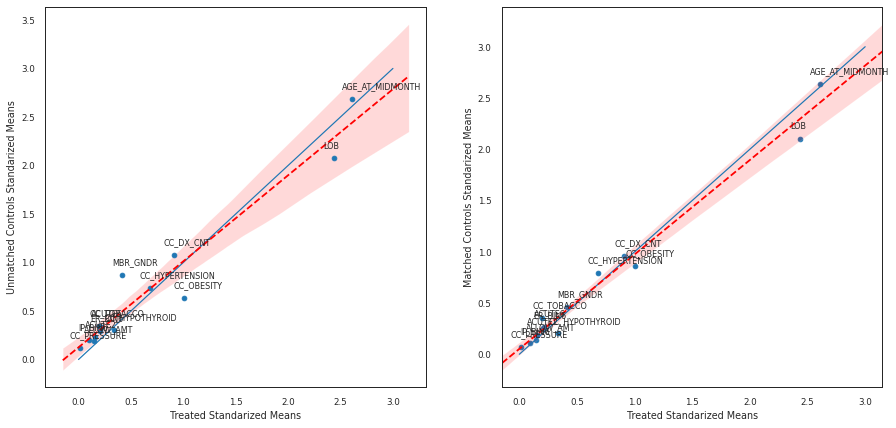

In [118]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].scatter(stdMeans['Treated'], stdMeans['Controls'])
ax[1].scatter(stdMeans['Treated'], stdMeans['MControls'])
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['MControls'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(stdMeans.index)):
    ax[0].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['Controls'].iloc[i]), fontsize = 'small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['MControls'].iloc[i]),fontsize = 'small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.savefig("./Final/results/pca/figures/std_means_graph.png")
fig.show()

# Ratio Stats

In [120]:
disease_cols = [cols for cols in treated.columns if "CC" in cols and cols!='CC_DX_CNT']
other_binary_cols = ['MBR_GNDR', 'LOB', 'PREGNANCY', 'IP_BIN', 'ER_BIN', 'ACUTE']
binary_cols = other_binary_cols + disease_cols 
restricted_cols = ['PERS_ID', 'MYR', 'MEDICAID_LOB']
continuous_cols = [cols for cols in treated.columns if cols not in binary_cols + restricted_cols]

In [121]:
def calculate_continuous_d(t, c):
    Xt = np.mean(t)
    Xc = np.mean(c)
    St = np.std(t)
    Sc = np.std(c)
    d = np.abs((Xt-Xc)/(np.sqrt((St**2 + Sc**2)/2)))
    return d

In [122]:
def calculate_binary_d(t, c):
    Pt = np.mean(t)
    Pc = np.mean(c)
    d = np.abs((Pt-Pc)/(np.sqrt((Pt*(1-Pt)+Pc*(1-Pc))/2)))
    return d

In [124]:
d_metric_before = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, controls_original[[col]].values)
        d_metric_before.loc[0,col] = d

In [125]:
d_metric_before

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0   0.54025         0.038863   0.017102  0.007147  0.021577  0.018774      0.121471           0.202374  0.053294   0.046514             0.105468      0.025743   0.084555       0.145405   0.096304    0.034489  0.145498          0.076516     0.043088            0.01594           0.272186              0.049306  0.13852             0.02959       0.061509                 0.062788            0.05059     0.397714         0.121306   0.080205               0.011875     0.058982         0.005191     0.065073           0.051957          0.133201        0.013848              0.002869                0.019984               0.02383                0.065898                    0.046573        0.005502        0.004032          0.071051         0.059537           0.097063         0.050973        0.043779      0.068314     0.172573        0.053973      0.004021  0.031985        0.048055     0.180443            0.061977               0.061581               0.029496    0.486435         0.084021   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE      IP_C      ER_C   ACUTE_C   IP_BIN6   ER_BIN6  ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  
0       0.192597        0.005469     0.129215            0.099813  0.026201          0.080329                0.115778        0.049092         0.007018   0.066658    0.154327            0.010869          0.046064  0.460482   0.034817  0.068095  0.066718  0.088808  0.075701  0.006985  0.017054  0.137033  0.117808  0.1595  0.090354  0.084982  0.113792

In [126]:
d_metric_before.T.to_csv("./Final/results/pca/stats_matching/d_metric_before.csv", header=True, index=True)

In [127]:
d_metric_before.T[d_metric_before.T[0]<0.1].size

65

In [128]:
d1 = d_metric_before.loc[:,:'LOB']

In [129]:
d1

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0   0.54025         0.038863   0.017102  0.007147  0.021577  0.018774      0.121471           0.202374  0.053294   0.046514             0.105468      0.025743   0.084555       0.145405   0.096304    0.034489  0.145498          0.076516     0.043088            0.01594           0.272186              0.049306  0.13852             0.02959       0.061509                 0.062788            0.05059     0.397714         0.121306   0.080205               0.011875     0.058982         0.005191     0.065073           0.051957          0.133201        0.013848              0.002869                0.019984               0.02383                0.065898                    0.046573        0.005502        0.004032          0.071051         0.059537           0.097063         0.050973        0.043779      0.068314     0.172573        0.053973      0.004021  0.031985        0.048055     0.180443            0.061977               0.061581               0.029496    0.486435         0.084021   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  
0       0.192597        0.005469     0.129215            0.099813  0.026201          0.080329                0.115778        0.049092         0.007018   0.066658    0.154327            0.010869          0.046064  0.460482

In [130]:
d1.T[d1.T[0]<0.1].size

56

In [131]:
d_metric_after = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        d_metric_after.loc[0,col] = d

In [132]:
d_metric_after.T.to_csv("./Final/results/pca/stats_matching/d_metric_after.csv", header=True, index=True)

In [133]:
d_metric_after.T[d_metric_after.T[0]<0.1].size

70

In [134]:
d2 = d_metric_after.loc[:,:'LOB']

In [135]:
d2.T[d2.T[0]<0.1].size

57

In [136]:
ratio = d_metric_after/d_metric_before
ratio

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.110425         0.966217   1.665603  0.428282  0.051337  3.05431      0.433278            0.41115  0.193522   1.894124             0.579635      3.081328   0.405932       0.737786   0.345921    1.808089  0.023278          2.526271      1.39906           2.090382           0.467801              0.732083  0.509487            0.220862       0.187807                 0.129149           0.197699     0.373077         0.379581   0.459521               2.555957     0.270691         4.685885     0.184905           0.127899          0.524838         1.28667              7.685002                0.118451              0.489479                0.501229                    0.747453             NaN             NaN          0.497961         0.479964           1.166819         2.003578        2.568679      0.219107     1.124559        0.104958      8.820664  0.167612        1.020898     1.133807             0.37656               1.793681                    NaN    0.485355         0.001485   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE      IP_C      ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  
0       0.655371        9.403475     0.589367             0.29011  3.827991          0.126972                 0.25992        0.436321         4.525342   0.725845    1.214977            0.950922          0.186924  0.981243   0.255578  0.319374  0.461059  0.414806  0.033463  6.599938  2.693425  0.335802  0.474317  0.441086  0.327529  0.472585  0.428456

In [137]:
ratio.T[ratio.T[0]>=1.0].size

26

In [138]:
ratio.T.to_csv("./Final/results/pca/stats_matching/ratio.csv", header=True, index=True)

In [ ]:
!aws s3 cp ../Final/Data/PCA_o s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/PCAFixedFinalOnemodel --recursive --acl bucket-owner-full-control